In [1]:
from azureml.core import Workspace, Experiment, Dataset, Datastore, Model
from azureml.exceptions import UserErrorException
import pandas as pd

ws = Workspace.from_config()

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


In [2]:
dataset_name = 'diamonds'

In [3]:
try:
    diamond_dataset = Dataset.get_by_name(ws, name=dataset_name, version=1)
    df = diamond_dataset.to_pandas_dataframe()
except UserErrorException:
    print("Failed to find a dataset by this name. Try to register a new one")
    
    # Load the data from somewhere
    df = pd.read_csv('./data/diamons.csv')
    
    # Extract the relevant features
    df= df[['carat', 'table', 'cut', 'color', 'clarity', 'depth', 'x', 'y', 'z', 'price']]
    datastore = Datastore.get_default(ws)
    
    # Register the dataset
    diamond_dataset = Dataset.Tabular.register_pandas_dataframe(
        df,
        datastore, 
        show_progress=True, 
        name='diamonds', 
        description='Diamonds'
    )

# Inspecting the data

Our goal is to build a simple regressor that can estimate the price of a diamond given a set of characteristics. We use a precompiled dataset with 9 feature columns and a price column. 
We start by inspecting what features we have available to us.

About the data

- price price in US dollars (326--18,823)
- carat weight of the diamond (0.2--5.01)
- cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color diamond colour, from J (worst) to D (best)
- clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- x length in mm (0--10.74)
- y width in mm (0--58.9)
- z depth in mm (0--31.8)
- depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
- table width of top of diamond relative to widest point (43--95)

# Visualize the Data
Just for fun we can visualize the data to see how it looks.

In [4]:
# Allows us to render png images with plotly
!pip install -U kaleido

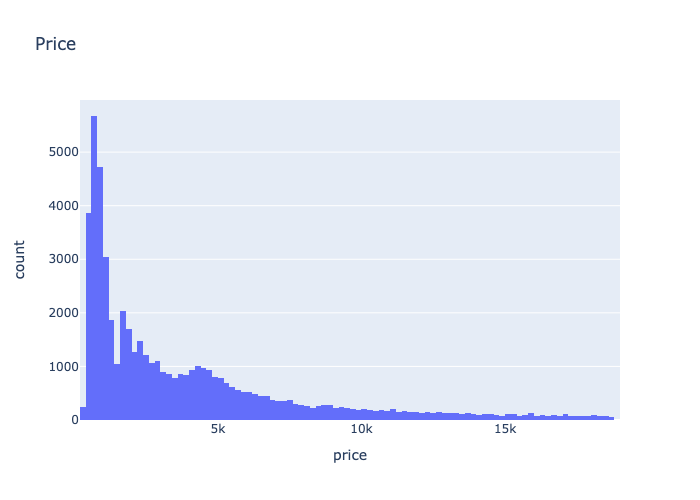

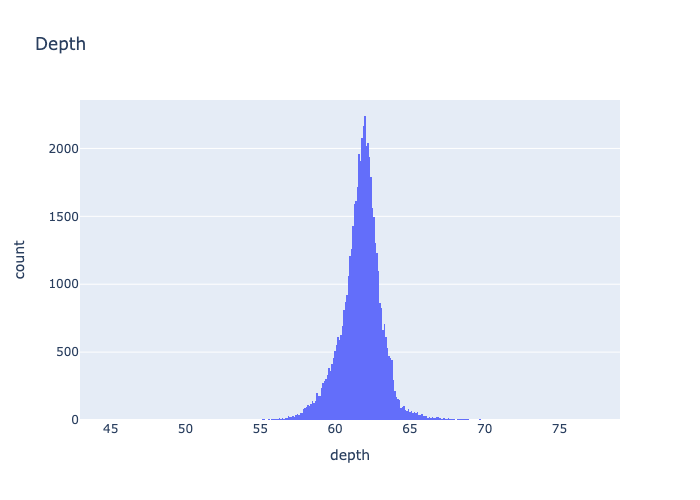

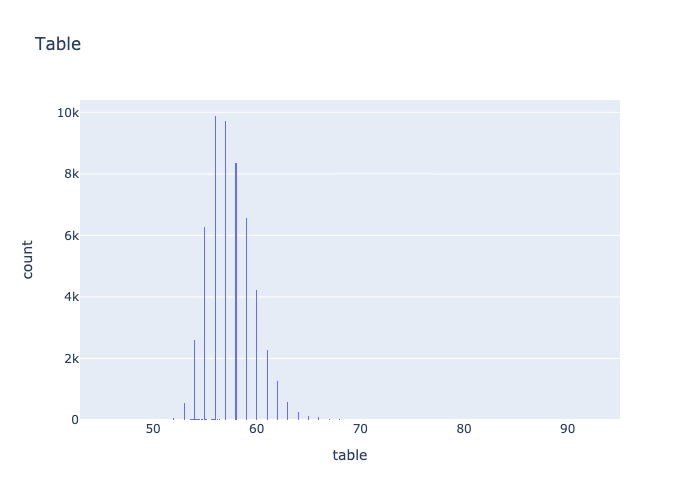

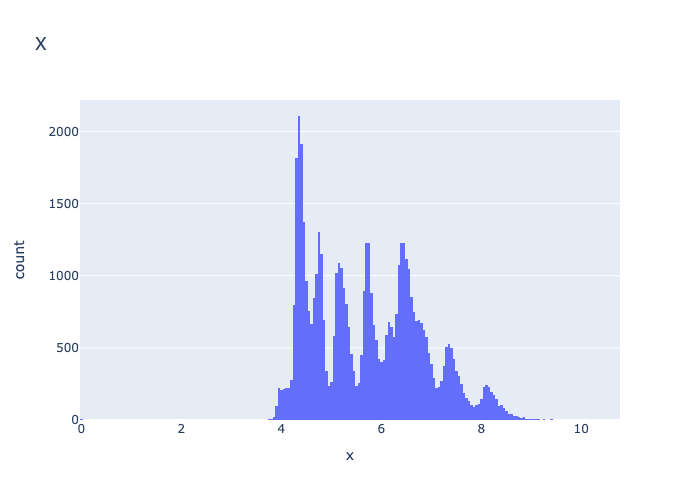

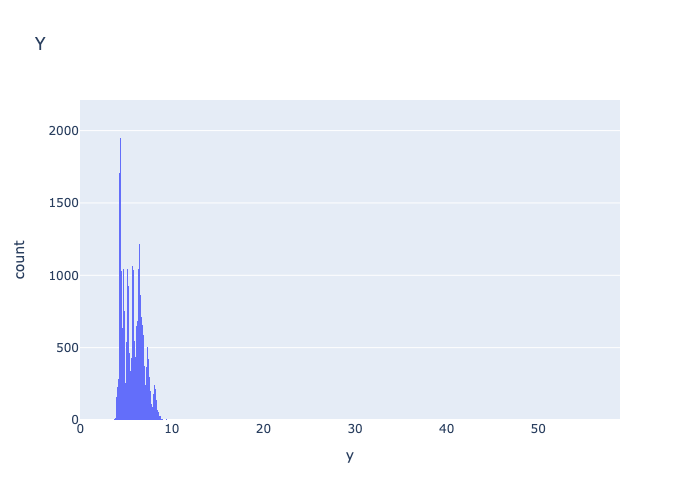

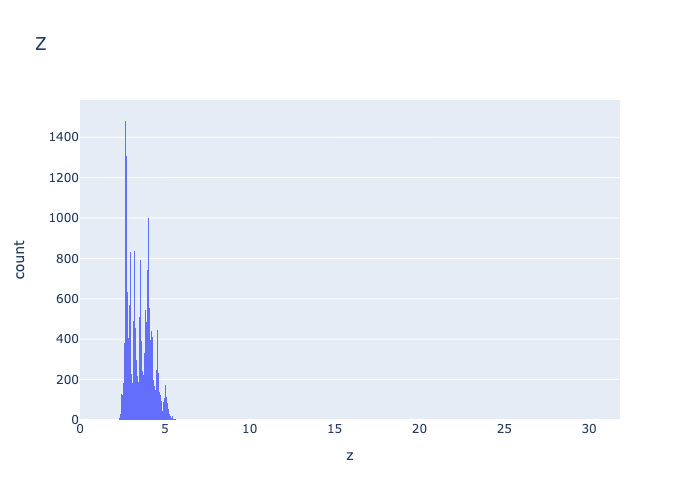

In [5]:
import plotly.express as px

px.histogram(df, x='price', title="Price").show("png")
px.histogram(df, x='depth', title="Depth").show("png")
px.histogram(df, x='table', title="Table").show("png")
px.histogram(df, x='x', title="X").show("png")
px.histogram(df, x='y', title="Y").show("png")
px.histogram(df, x='z', title="Z").show("png")

## Features relation to price
We  suspect that the carat of the diamond, e.g., its size, is closely related to the price. We can try to confirm this hypothesis via a scatter plot.

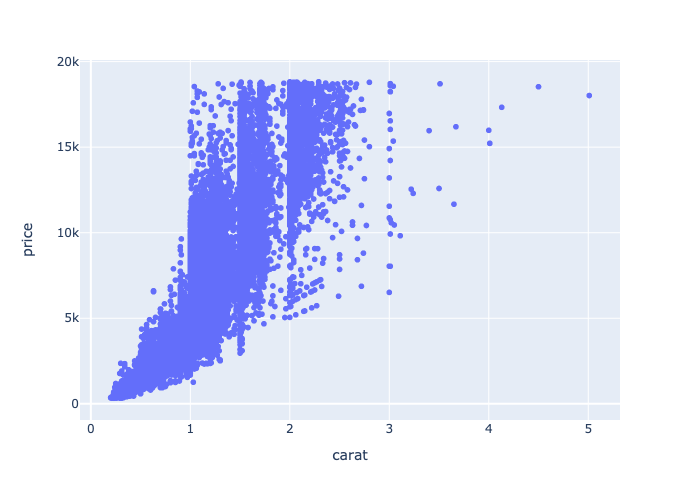

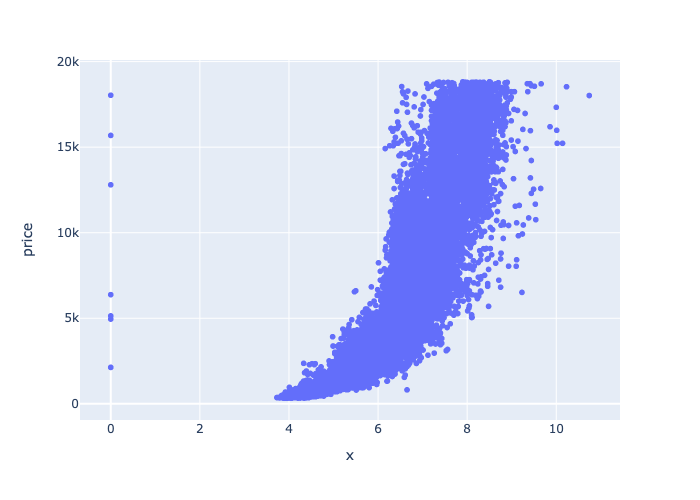

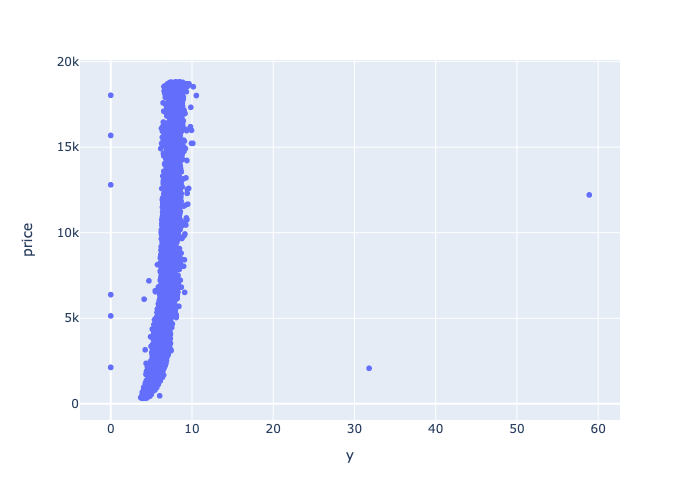

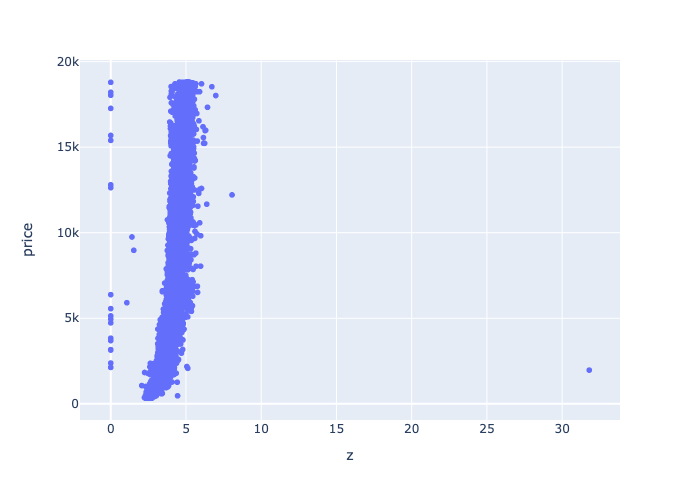

In [6]:
px.scatter(df, x='carat', y='price').show("png")
px.scatter(df, x='x', y='price').show("png")
px.scatter(df, x='y', y='price').show("png")
px.scatter(df, x='z', y='price').show("png")

# Relation between categorical columns and price
We can try to see if there is some distinct groups of diamonds if we visualize the price, carat and some of the categorial features.
We can see that clarity har a stark correlation between price, where two equally sized diamonds can have significantly higher price if it is a VS1 rather than SI1.

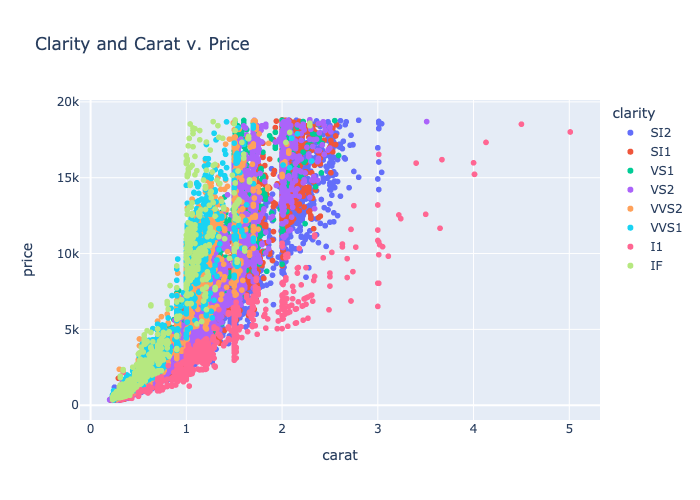

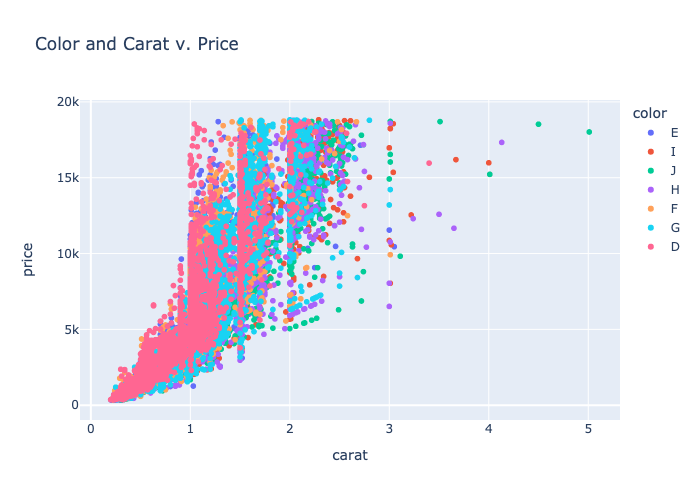

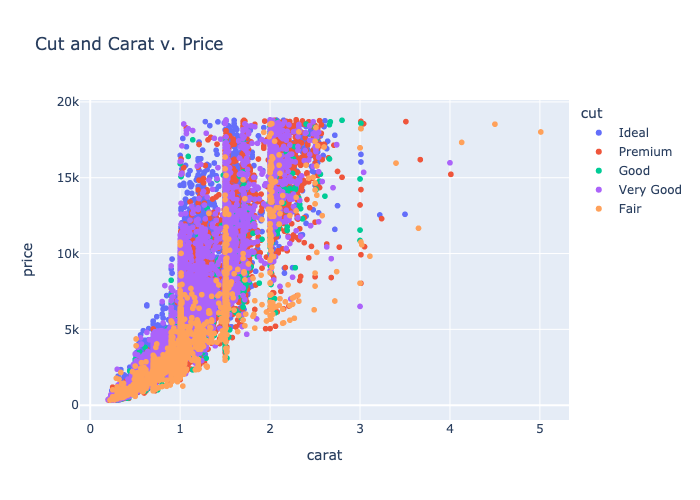

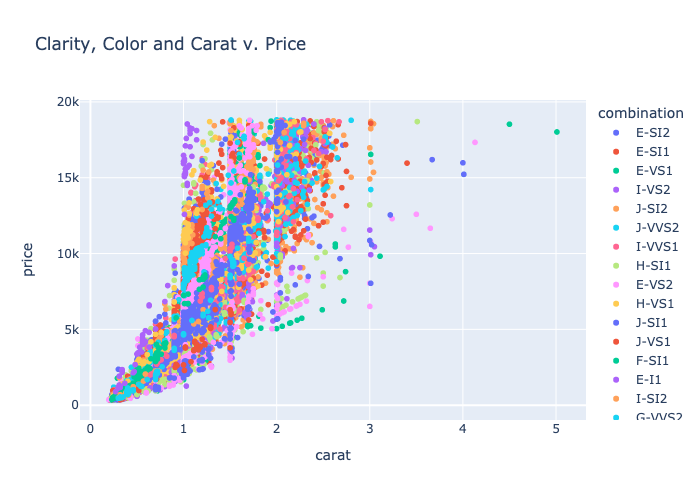

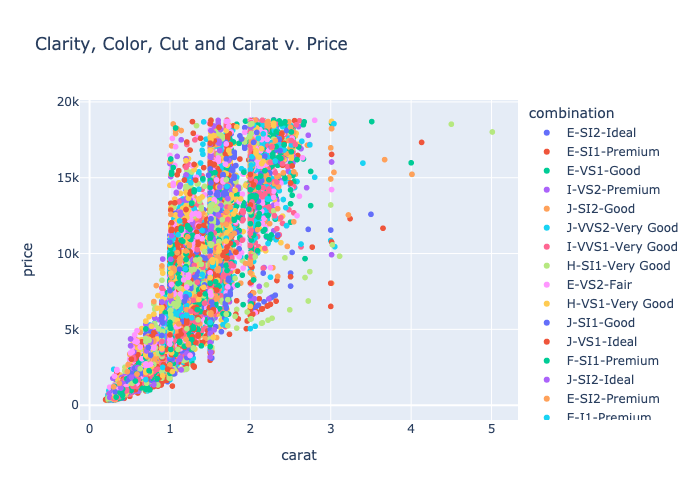

In [7]:
px.scatter(df, x='carat', y='price', color='clarity', title="Clarity and Carat v. Price").show("png")
px.scatter(df, x='carat', y='price', color='color', title="Color and Carat v. Price").show("png")
px.scatter(df, x='carat', y='price', color='cut', title="Cut and Carat v. Price").show("png")

df_test = df.copy()
df_test['combination'] = df.apply(lambda row: f"{row['color']}-{row['clarity']}", axis=1)
px.scatter(df_test, x='carat', y='price', color='combination', title="Clarity, Color and Carat v. Price").show("png")

df_test = df.copy()
df_test['combination'] = df.apply(lambda row: f"{row['color']}-{row['clarity']}-{row['cut']}", axis=1)
px.scatter(df_test, x='carat', y='price', color='combination', title="Clarity, Color, Cut and Carat v. Price").show("png")

We can also plot some of the aggregate information of the clarity. Since larger diamonds are less likely to have the more expensive types of clarity, we note that the type of clarity with the highest median price is actually not the most expensive one.

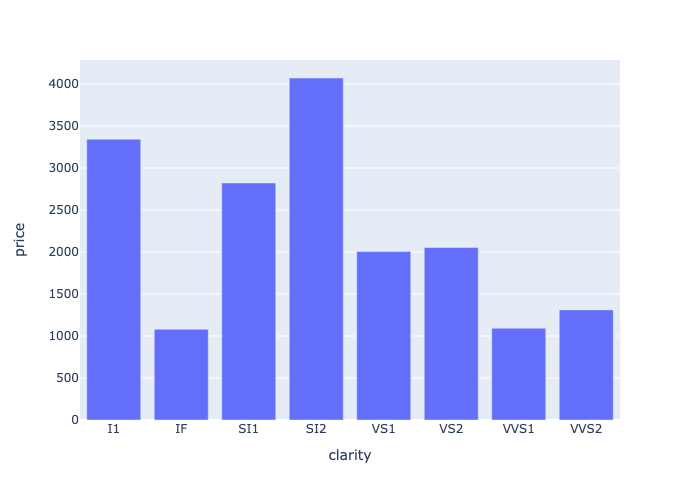

In [8]:
px.bar(df.groupby('clarity')['price'].median().reset_index(), x='clarity', y='price').show("png")

# Training a regressor
We start by using a Linear Regression due to it's simplicity. We use a MinAbsScaler to scale our numerical features since we don't want to loose sparsity in the data.

# Data Cleaning
We remove instances that have a diamond dimension of zero. We also remove all rows with a NaN value it.

In [9]:
def clean_dataframe(df):
    df = df.copy()

    # Filter out the zero values we observed before
    df = df[~((df['x'] == 0) | (df['y'] == 0) | (df['z'] == 0))]
    df = df.dropna()
    return df

In [10]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(clean_dataframe(df), test_size=0.2)
print("Size of the training set", len(df_train))
print("Size of the test set", len(df_test))

Size of the training set 43136
Size of the test set 10784


You can now optionally register the train and test split as separate dataset.

In [11]:
train_dataset_name = f"{dataset_name}-train"
try:
    train_dataset = Dataset.get_by_name(ws, name=train_dataset_name)
    df_train = train_dataset.to_pandas_dataframe()
except UserErrorException:
    print("No training dataset registered. Uploading our version")
    datastore = Datastore.get_default(ws)
    
    # Register the dataset
    train_dataset = Dataset.Tabular.register_pandas_dataframe(
        df_train,
        datastore, 
        show_progress=True, 
        name=train_dataset_name, 
        description='Diamonds Train Dataset'
    )

In [12]:
test_dataset_name = f"{dataset_name}-test"
try:
    test_dataset = Dataset.get_by_name(ws, name=test_dataset_name)
    df_test = test_dataset.to_pandas_dataframe()
except UserErrorException:
    print("No test dataset registered. Uploading our version")
    datastore = Datastore.get_default(ws)
    
    # Register the dataset
    test_dataset = Dataset.Tabular.register_pandas_dataframe(
        df_test,
        datastore, 
        show_progress=True, 
        name=test_dataset_name, 
        description='Diamonds Test Dataset'
    )

In [13]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import joblib

In [14]:
# Define the names of the experiment
experiment_name='diamond-regression-interactive-new-debug'
model_name="diamond-linear-regressor-new-debug"

In [15]:
experiment = Experiment(workspace=ws, name=experiment_name)
run = experiment.start_logging(snapshot_directory='.')

In [16]:
run.properties

{'azureml.git.branch': 'master',
 'mlflow.source.git.branch': 'master',
 'azureml.git.dirty': 'True',
 'ContentSnapshotId': '6e398b82-e132-4330-84d7-05e340bafa17'}

In [17]:
def prepare_data(df):
    df = df.copy()
    y = df.pop('price')
    return df, y

In [18]:
regressor = LinearRegression()
ct = make_column_transformer(
    (MaxAbsScaler(), make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(), make_column_selector(dtype_include=object)),
)

X_train, y_train = prepare_data(df_train)
X_test, y_test = prepare_data(df_test)

model = Pipeline([("ColumnTransformer", ct), ("Regressor", regressor)])
model.fit(X_train, y_train)
y_ = model.predict(X_test)

rmse = mean_squared_error(y_test, y_, squared=False)
r2 = r2_score(y_test, y_)
print("rmse", rmse)
print("r2", r2)

run.log("rmse", rmse)
run.log("r2", r2)

rmse 1136.2692396584414
r2 0.9185433338833685


In [19]:
from pathlib import Path
import joblib

path = Path("output", "model.pkl")
path.parent.mkdir(exist_ok=True)
joblib.dump(model, filename=str(path))

run.upload_file(str(path.name), path_or_stream=str(path))

all_models = Model.list(ws, name=model_name)
if all(r2 >  float(model.tags.get("r2", -np.inf)) for model in all_models):
    print("Found a new winner. Registering the model.")
    run.register_model(
        model_name=model_name,
        model_path=str(path.name),
        description="Linear Diamond Regression Model",
        model_framework="ScikitLearn",
        datasets=[("training dataset", train_dataset), ("test dataset", test_dataset)],
        tags={"rmse": rmse, "r2": r2}
    )

In [20]:
run.complete()

In [25]:
from azureml.core import Environment
environment = Environment(name="test")